## Test with the Karate Club dataset

In [245]:
# Always use keyword arguments for clarity and to avoid bugs
# Use type hints for function arguments and return values as much as possible
# Import libraries
from torch_geometric.utils import get_num_hops
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import torch
import networkx as nx
import numpy as np
from torch_geometric.utils import remove_self_loops, add_self_loops, get_num_hops
from torch_geometric.data import Data
from torch_geometric.datasets import KarateClub
from models import GAT_L2, GAT_L3, GAT_karate
from typing import Dict

In [3]:
# Define the dataset
data = KarateClub()[0]
# Initialize the model
num_classes = data.y.max().item() + 1
model = GAT_karate(data.num_features, 8, num_classes)
# Define the loss function
criterion = torch.nn.CrossEntropyLoss()
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move the model to the device
model = model.to(device)
# Move the data to the device
data = data.to(device)
# Train the model
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out, att = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

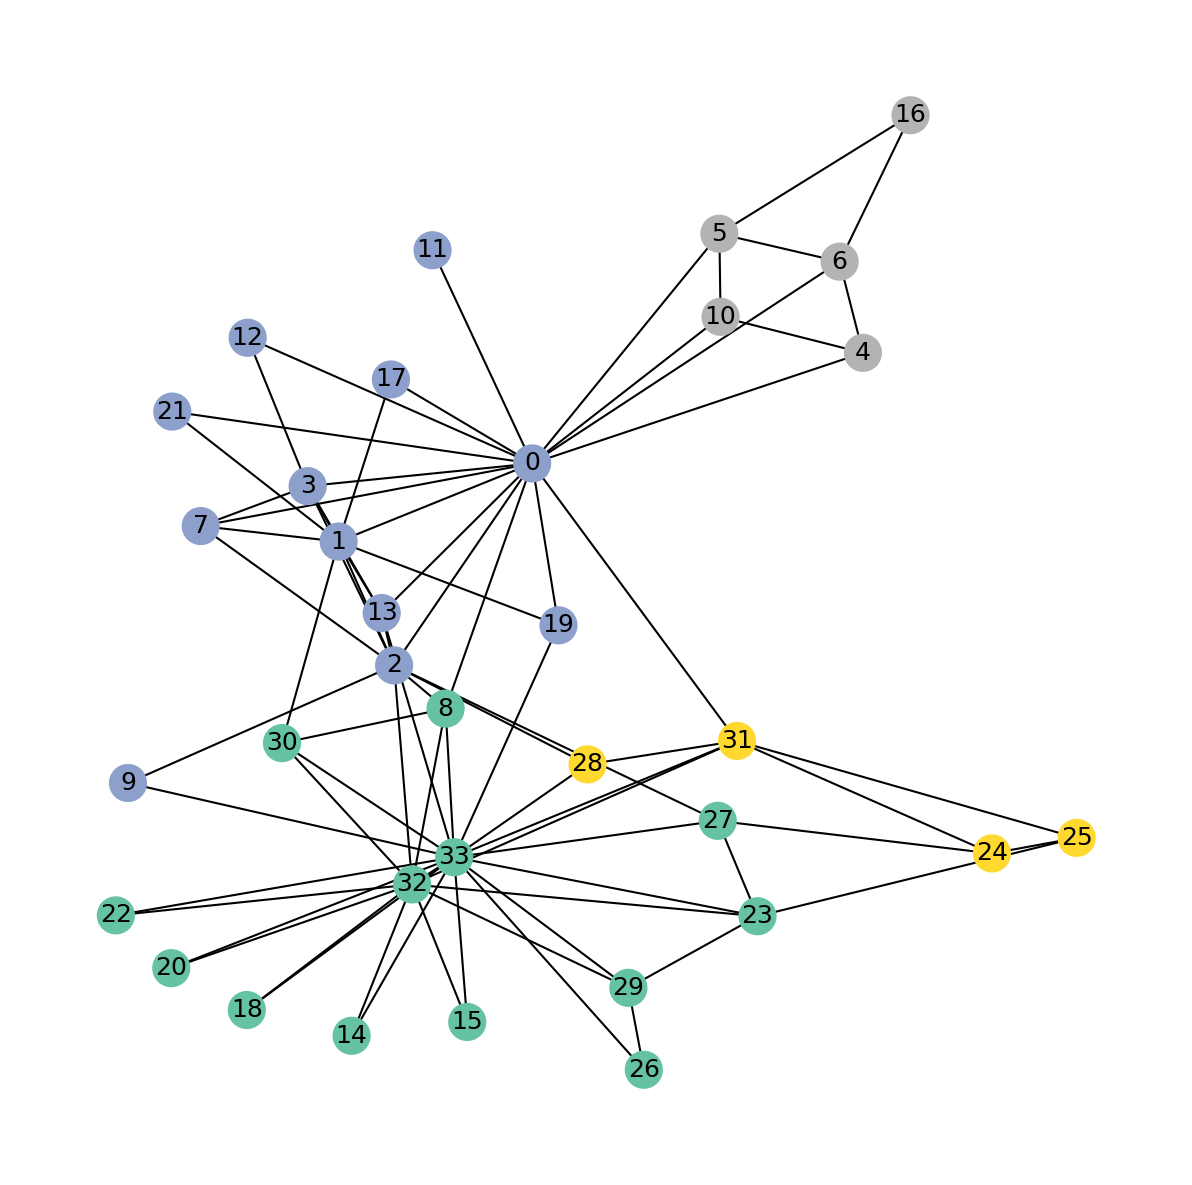

In [4]:
# First, visualize the karate dataset
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils.convert import to_networkx

# Convert the dataset to a networkx graph
G = to_networkx(data, to_undirected=True)

plt.figure(figsize=(10, 10), dpi=150)
nx.draw_networkx(
    G,
    pos=nx.spring_layout(G, seed=42),
    with_labels=True,
    node_color=data.y.cpu(),
    cmap="Set2",
)
# Remove the axis
plt.axis("off")
plt.show()

In [15]:
# Since k_hop_subgraph only returns the mapping of the target nodes to their new location, we need to get the mapping of all nodes to their new location
# We do this by modifying the source code of k_hop_subgraph
from typing import List, Optional, Tuple, Union, Dict
import torch
from torch import Tensor
from torch_geometric.utils.num_nodes import maybe_num_nodes


def k_hop_subgraph_modified(
    node_idx: int,
    num_hops: int,
    edge_index: Tensor,
    num_nodes: Optional[int] = None,
) -> Tuple[Tensor, Tensor, Tensor, Tensor, List[Tensor]]:
    num_nodes = maybe_num_nodes(edge_index, num_nodes)
    edge_index = add_self_loops(remove_self_loops(edge_index)[0], num_nodes=num_nodes)[
        0
    ]
    col, row = edge_index

    node_mask = row.new_empty(num_nodes, dtype=torch.bool)
    edge_mask = row.new_empty(row.size(0), dtype=torch.bool)

    node_idx = torch.tensor([node_idx], device=row.device).flatten()
    subsets = [node_idx]

    for _ in range(num_hops):
        node_mask.fill_(False)
        node_mask[subsets[-1]] = True
        torch.index_select(node_mask, 0, row, out=edge_mask)
        subsets.append(col[edge_mask])

    subset, inv = torch.cat(subsets).unique(return_inverse=True)
    edge_index = edge_index[:, edge_mask]

    node_idx = row.new_full((num_nodes,), -1)
    node_idx[subset] = torch.arange(subset.size(0), device=row.device)
    edge_index = node_idx[edge_index]

    new_levels = []
    for level in subsets:
        new_levels.append(node_idx[level])

    return subset, edge_index, inv, edge_mask, new_levels


# Before acquiring the full computation graph, get the attention weights of the target node
@torch.no_grad()
def get_attention_weights_karate(
    k_hop_edge_index: Tensor, subset: Tensor, model=model
) -> Tuple:
    k_hop_edge_index = k_hop_edge_index.to("cuda")
    k_hop_edge_index = remove_self_loops(k_hop_edge_index)[0]
    new_x = data.x[subset].to("cuda")
    model(new_x, k_hop_edge_index)
    return model.att


@torch.no_grad()
def get_attention_weights(
    k_hop_edge_index: Tensor, subset: Tensor, model=model
) -> Tuple:
    k_hop_edge_index = k_hop_edge_index.to("cuda")
    k_hop_edge_index = remove_self_loops(k_hop_edge_index)[0]
    new_x = data.x[subset].to("cuda")
    model(
        new_x, k_hop_edge_index, return_att=True
    )  # just run the model once to get the attention weights
    num_layers = get_num_hops(model)
    if num_layers == 2:
        att = (model.att1, model.att2)
    elif num_layers == 3:
        att = (model.att1, model.att2, model.att3)
    else:
        raise ValueError("The model is not GAT_L2 or GAT_L3")
    return att


def get_computation_graph(
    edge_index: Tensor, k: int, target_idx: int
) -> dict[int, Tensor]:
    """
    Returns the computation graph of the k-hop subgraph.
    We are expecting the inputs to be the ORIGINAL DATA INDICES.
    The first row of edge_index is the source, and the second row is the target.
    """
    edge_index = add_self_loops(remove_self_loops(edge_index)[0])[0]
    # Initialize the computation graph dictionary
    comp_graph = {}
    # Start by getting the neighbors of the target node
    curr_edge_index = edge_index[:, edge_index[1] == target_idx]
    comp_graph[0] = curr_edge_index.cpu()
    # Repeat the process for the rest of the layers recursively.
    for layer in range(1, k):
        # Get the neighbors of the current layer
        new_targets = curr_edge_index[0, :]
        # Initialize the final edge index tensor
        final_edge_index = []
        for target in new_targets:
            # Get the neighbors of the new targets
            temp_edge_index = edge_index[:, edge_index[1] == target]
            final_edge_index.append(temp_edge_index)
        final_edge_index = torch.cat(final_edge_index, dim=1).cpu()
        # Add the new edge_index to the computation graph dictionary
        comp_graph[layer] = final_edge_index
        curr_edge_index = final_edge_index

    return comp_graph


def get_computation_graph_local(
    edge_index: Tensor, k: int, shifted_target_idx: int
) -> dict[int, Tensor]:
    """
    Returns the computation graph of the k-hop subgraph.
    We are expecting the inputs to be the output of k_hop_subgraph_modified.
    Therefore, the target node index is always 0.
    The first row of edge_index is the source, and the second row is the target.
    """
    edge_index = add_self_loops(remove_self_loops(edge_index)[0])[0]
    # Initialize the computation graph dictionary
    comp_graph = {}
    # Start by getting the neighbors of the target node
    curr_edge_index = edge_index[:, edge_index[1] == shifted_target_idx]
    comp_graph[0] = curr_edge_index.cpu()
    # Repeat the process for the rest of the layers recursively.
    for layer in range(1, k):
        # Get the neighbors of the current layer
        new_targets = curr_edge_index[0, :]
        # Initialize the final edge index tensor
        final_edge_index = []
        for target in new_targets:
            # Get the neighbors of the new targets
            temp_edge_index = edge_index[:, edge_index[1] == target]
            final_edge_index.append(temp_edge_index)
        final_edge_index = torch.cat(final_edge_index, dim=1).cpu()
        # Add the new edge_index to the computation graph dictionary
        comp_graph[layer] = final_edge_index
        curr_edge_index = final_edge_index

    return comp_graph


# Draw the attention weights of the target node for a given layer
def draw_attention_weights(att_tuple: Tuple, layer: int) -> None:
    curr_edge_index = att_tuple[layer][0]
    edge_with_att = []
    for idx, att in enumerate(att_tuple[layer][1].flatten().cpu()):
        edge_with_att.append(
            (curr_edge_index[0][idx].item(), curr_edge_index[1][idx].item(), att.item())
        )
    # Create a temporary graph to draw the attention weights
    G_temp = nx.Graph()
    G_temp.add_weighted_edges_from(edge_with_att)
    # Draw the graph with weighted edges as the attention weights with color
    pos = nx.spring_layout(G_temp, seed=42)
    edges = G_temp.edges()
    weights = [G_temp[u][v]["weight"] for u, v in edges]
    plt.figure(figsize=(10, 10), dpi=100)
    nx.draw_networkx_nodes(G_temp, pos, node_color="tab:blue", node_size=200)
    nx.draw_networkx_labels(G_temp, pos)
    nx.draw_networkx_edges(
        G_temp, pos, edgelist=edges, edge_color=weights, edge_cmap=plt.cm.Blues, width=2
    )
    plt.show()


# Return the attention weights as a dictionary
def get_attention_weights_dict(att_tuple: Tuple, layer: int) -> Dict:
    curr_edge_index = att_tuple[layer][0]
    edge_with_att = []
    for idx, att in enumerate(att_tuple[layer][1].flatten().cpu()):
        edge_with_att.append(
            (
                (curr_edge_index[0][idx].item(), curr_edge_index[1][idx].item()),
                att.item(),
            )
        )
    return dict(edge_with_att)


# Deprecated
def get_attention_weights_dict_all(att_tuple: Tuple) -> Dict:
    att_dict = {}
    for layer in range(len(att_tuple)):
        att_dict[layer] = get_attention_weights_dict(att_tuple=att_tuple, layer=layer)
    return att_dict


def translate_comp_graph(comp_graph, nodes_per_level_new, nodes_per_level_original):
    new_comp_graph = {}
    for key, value in comp_graph.items():
        curr_tgt = value[1]
        new_src = nodes_per_level_new[key + 1]
        new_tgt = torch.zeros_like(curr_tgt)

        curr_idx = 0
        for idx, node in enumerate(curr_tgt):
            # Check node corresponds to the nodes_per_level_original[key][curr_idx]
            if node == nodes_per_level_original[key][curr_idx]:
                new_tgt[idx] = nodes_per_level_new[key][curr_idx]
            # If not, check if node corresponds to the nodes_per_level_original[key][curr_idx+1]
            else:
                curr_idx += 1
                new_tgt[idx] = nodes_per_level_new[key][curr_idx]

        new_comp_graph[key] = torch.stack([new_src, new_tgt], dim=0)
    return new_comp_graph


def get_node_positions(nodes_per_level_new):
    node_pos_new = {}
    # Define the y position of the nodes in each level
    y_pos = torch.linspace(1, -1, len(nodes_per_level_new))
    for idx, nodes in enumerate(nodes_per_level_new):
        # Define the x position of the nodes in each level
        x_pos = torch.linspace(-1, 1, len(nodes))
        for node_idx, node in enumerate(nodes):
            node_pos_new[node.item()] = (x_pos[node_idx].item(), y_pos[idx].item())
    node_pos_new[0] = (0, 1)
    return node_pos_new


def get_edge_weights_dict(comp_graph, new_comp_graph, att_tuple):
    new_att_dict = {}
    for layer in range(len(att_tuple)):
        curr_new_edge_index = new_comp_graph[layer]
        curr_edge_index = comp_graph[layer]
        curr_att_data = att_tuple[-1 - layer]

        # Convert curr_att_data to a dictionary
        curr_att_dict = {}
        for idx in range(curr_att_data[0].shape[1]):
            curr_edge = (
                curr_att_data[0][0][idx].item(),
                curr_att_data[0][1][idx].item(),
            )
            curr_att_dict[curr_edge] = curr_att_data[1][idx].item()

        num_edges = curr_edge_index.shape[1]

        for idx in range(num_edges):
            curr_edge = (curr_edge_index[0][idx].item(), curr_edge_index[1][idx].item())
            curr_att = curr_att_dict[curr_edge]
            curr_new_edge = (
                curr_new_edge_index[0][idx].item(),
                curr_new_edge_index[1][idx].item(),
            )
            new_att_dict[curr_new_edge] = curr_att
    return new_att_dict


def get_nodes_per_level_from_comp_graph(comp_graph, subset):
    # Get list of nodes for each level, in the original node index
    nodes_per_level_original = [
        comp_graph[0][1][0].cpu().view(1)
    ]  # Initialize the list with the target node
    for idx in range(len(comp_graph)):
        nodes_per_level_original.append(comp_graph[idx][0].cpu())
    # And get the number of nodes in each level
    num_nodes_per_level = torch.tensor(
        [len(node_tensor) for node_tensor in nodes_per_level_original]
    )
    # And the true node label (for visualization)
    nodes_per_level_original_concat = torch.cat(nodes_per_level_original, dim=0)
    true_node_label = dict(
        zip(
            range(len(nodes_per_level_original_concat)),
            subset[nodes_per_level_original_concat].tolist(),
        )
    )
    return nodes_per_level_original, num_nodes_per_level, true_node_label


def reindex_nodes_per_level(nodes_per_level_original, num_nodes_per_level):
    # Redefine the node indices
    nodes_per_level_new = []
    for idx, num_nodes in enumerate(num_nodes_per_level):
        nodes_per_level_new.append(
            torch.arange(
                (num_nodes_per_level[:idx]).sum(),
                (num_nodes_per_level[: idx + 1]).sum(),
            )
        )
    return nodes_per_level_new


"""
Prepare & draw the computation graph
We perform several things during the prep stage:
1. Re-define the node indices to a ascending order, starting from 0 (root / target node) and ending with the last node in the last layer.
2. Equip the edges with the attention weights (we will accept the output of get_attention_weights_dict as input).
3. Equip the nodes with the node positions in the figure.
"""


def prep_for_comp_graph_vis(
    comp_graph: Dict, att_tuple: Tuple, subset: torch.tensor
) -> None:
    # First, get the nodes per level from comp_graph
    (
        nodes_per_level_original,
        num_nodes_per_level,
        true_node_label,
    ) = get_nodes_per_level_from_comp_graph(comp_graph, subset)

    # Second, reindex the nodes_per_level to a ascending order, starting from 0 (root / target node) and ending with the last node in the last layer.
    nodes_per_level_new = reindex_nodes_per_level(
        nodes_per_level_original, num_nodes_per_level
    )

    # Third, get the node positions in the figure
    node_pos_new = get_node_positions(nodes_per_level_new)

    # Fourth, reindex the comp_graph
    new_comp_graph = translate_comp_graph(
        comp_graph, nodes_per_level_new, nodes_per_level_original
    )

    # Fifth, equip the edges with the attention weights
    new_att_dict = get_edge_weights_dict(comp_graph, new_comp_graph, att_tuple)

    # Now, we can visualize the graph. First, make a networkx graph, then use matplotlib to visualize it.
    comp_G = nx.DiGraph()
    comp_G.add_edges_from(new_att_dict)

    for u, v, d in comp_G.edges(data=True):
        d["weight"] = new_att_dict[(u, v)]

    edges, weights = zip(*nx.get_edge_attributes(comp_G, "weight").items())
    plt.figure(
        figsize=(len(nodes_per_level_new[-1]) + 2, 2 * len(nodes_per_level_new)),
        dpi=150,
    )
    nx.draw(
        comp_G,
        pos=node_pos_new,
        labels=true_node_label,
        with_labels=True,
        node_size=2000,
        font_size=30,
        font_color="white",
        edge_cmap=plt.cm.Blues,
        width=2,
        edge_color=weights,
        edgelist=edges,
    )
    plt.show()

In [ ]:
target_node = 16
num_layers = 2

subset, local_edge_index, inv, edge_mask, new_levels = k_hop_subgraph_modified(
    node_idx=target_node, num_hops=num_layers, edge_index=data.edge_index
)
comp_graph = get_computation_graph_local(
    edge_index=local_edge_index, k=num_layers, shifted_target_idx=inv[0]
)
att_tuple = get_attention_weights_karate(
    k_hop_edge_index=local_edge_index, subset=subset, model=model
)
att_edge_dict = get_attention_weights_dict_all(att_tuple=att_tuple)
prep_for_comp_graph_vis(comp_graph=comp_graph, att_tuple=att_tuple, subset=subset)

## Test with the infection dataset

### Test with a smaller infection dataset

In [1]:
from torch_geometric.utils import get_num_hops
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import torch
import networkx as nx
import numpy as np
from torch_geometric.utils import (
    remove_self_loops,
    add_self_loops,
    get_num_hops,
    to_networkx,
)
from torch_geometric.data import Data
from torch_geometric.datasets import KarateClub
from models import GAT_L2, GAT_L3, GAT_karate
from typing import Dict
from infection_benchmark import create_infection_dataset

In [2]:
# data = create_infection_dataset(num_nodes=80, infected_portion=0.1, edge_prob=0.03, max_dist=3)

In [3]:
def draw_infection_data(data, ax=None, figsize=(16, 16), dpi=200):
    # Get the number of classes for data
    num_classes = data.y.max().item() + 1
    # Set the size of the figure with dpi=200
    fig = plt.figure(figsize=figsize, dpi=dpi)
    # Create a new axis if ax is None
    if ax is None:
        ax = fig.add_subplot(111)
    # Convert the data to networkx graph
    g = to_networkx(data)
    # Create a colormap for the labels
    cmap = plt.get_cmap("autumn", data.num_classes)
    # Create a list of colors for the nodes
    # where its color is determined by the label.
    node_colors = [cmap(data.y[i].item() / num_classes) for i in range(data.num_nodes)]
    unique_solution_explanations = {
        node: f"{data.y[node].item()}" for node in data.unique_solution_nodes
    }
    # Draw the graph with node outline as black
    nx.draw(
        g,
        pos=nx.kamada_kawai_layout(g),
        node_color=node_colors,
        edgecolors="black",
        ax=ax,
        labels=unique_solution_explanations,
        arrows=True,
    )
    # Draw the legend
    # Create a list of handles for the legend
    handles = [
        plt.Line2D(
            [],
            [],
            color=cmap(i / num_classes),
            marker="o",
            linestyle="",
            label=f"Length {i}",
        )
        for i in range(data.num_classes)
    ]
    # Explicitly mention infected nodes in legend
    handles[0].set_label(f"Infected nodes")
    # Replace the highest category by appending + symbol
    handles[-1].set_label(f"Length {data.num_classes - 1}+")

    # Make some adjustments
    ax.legend(
        handles=handles,
        loc="upper right",
        fontsize=15,
    )
    # Remove the axis
    ax.axis("off")
    # Set the title, including the number of nodes, number of ground truth shortest paths
    # and the number of unique shortest paths
    ax.set_title(
        f"Number of nodes: {data.num_nodes}\n"
        f"Number of unique shortest paths: {len(data.unique_solution_nodes)}",
        fontsize=20,
    )
    # Show the plot
    plt.show()

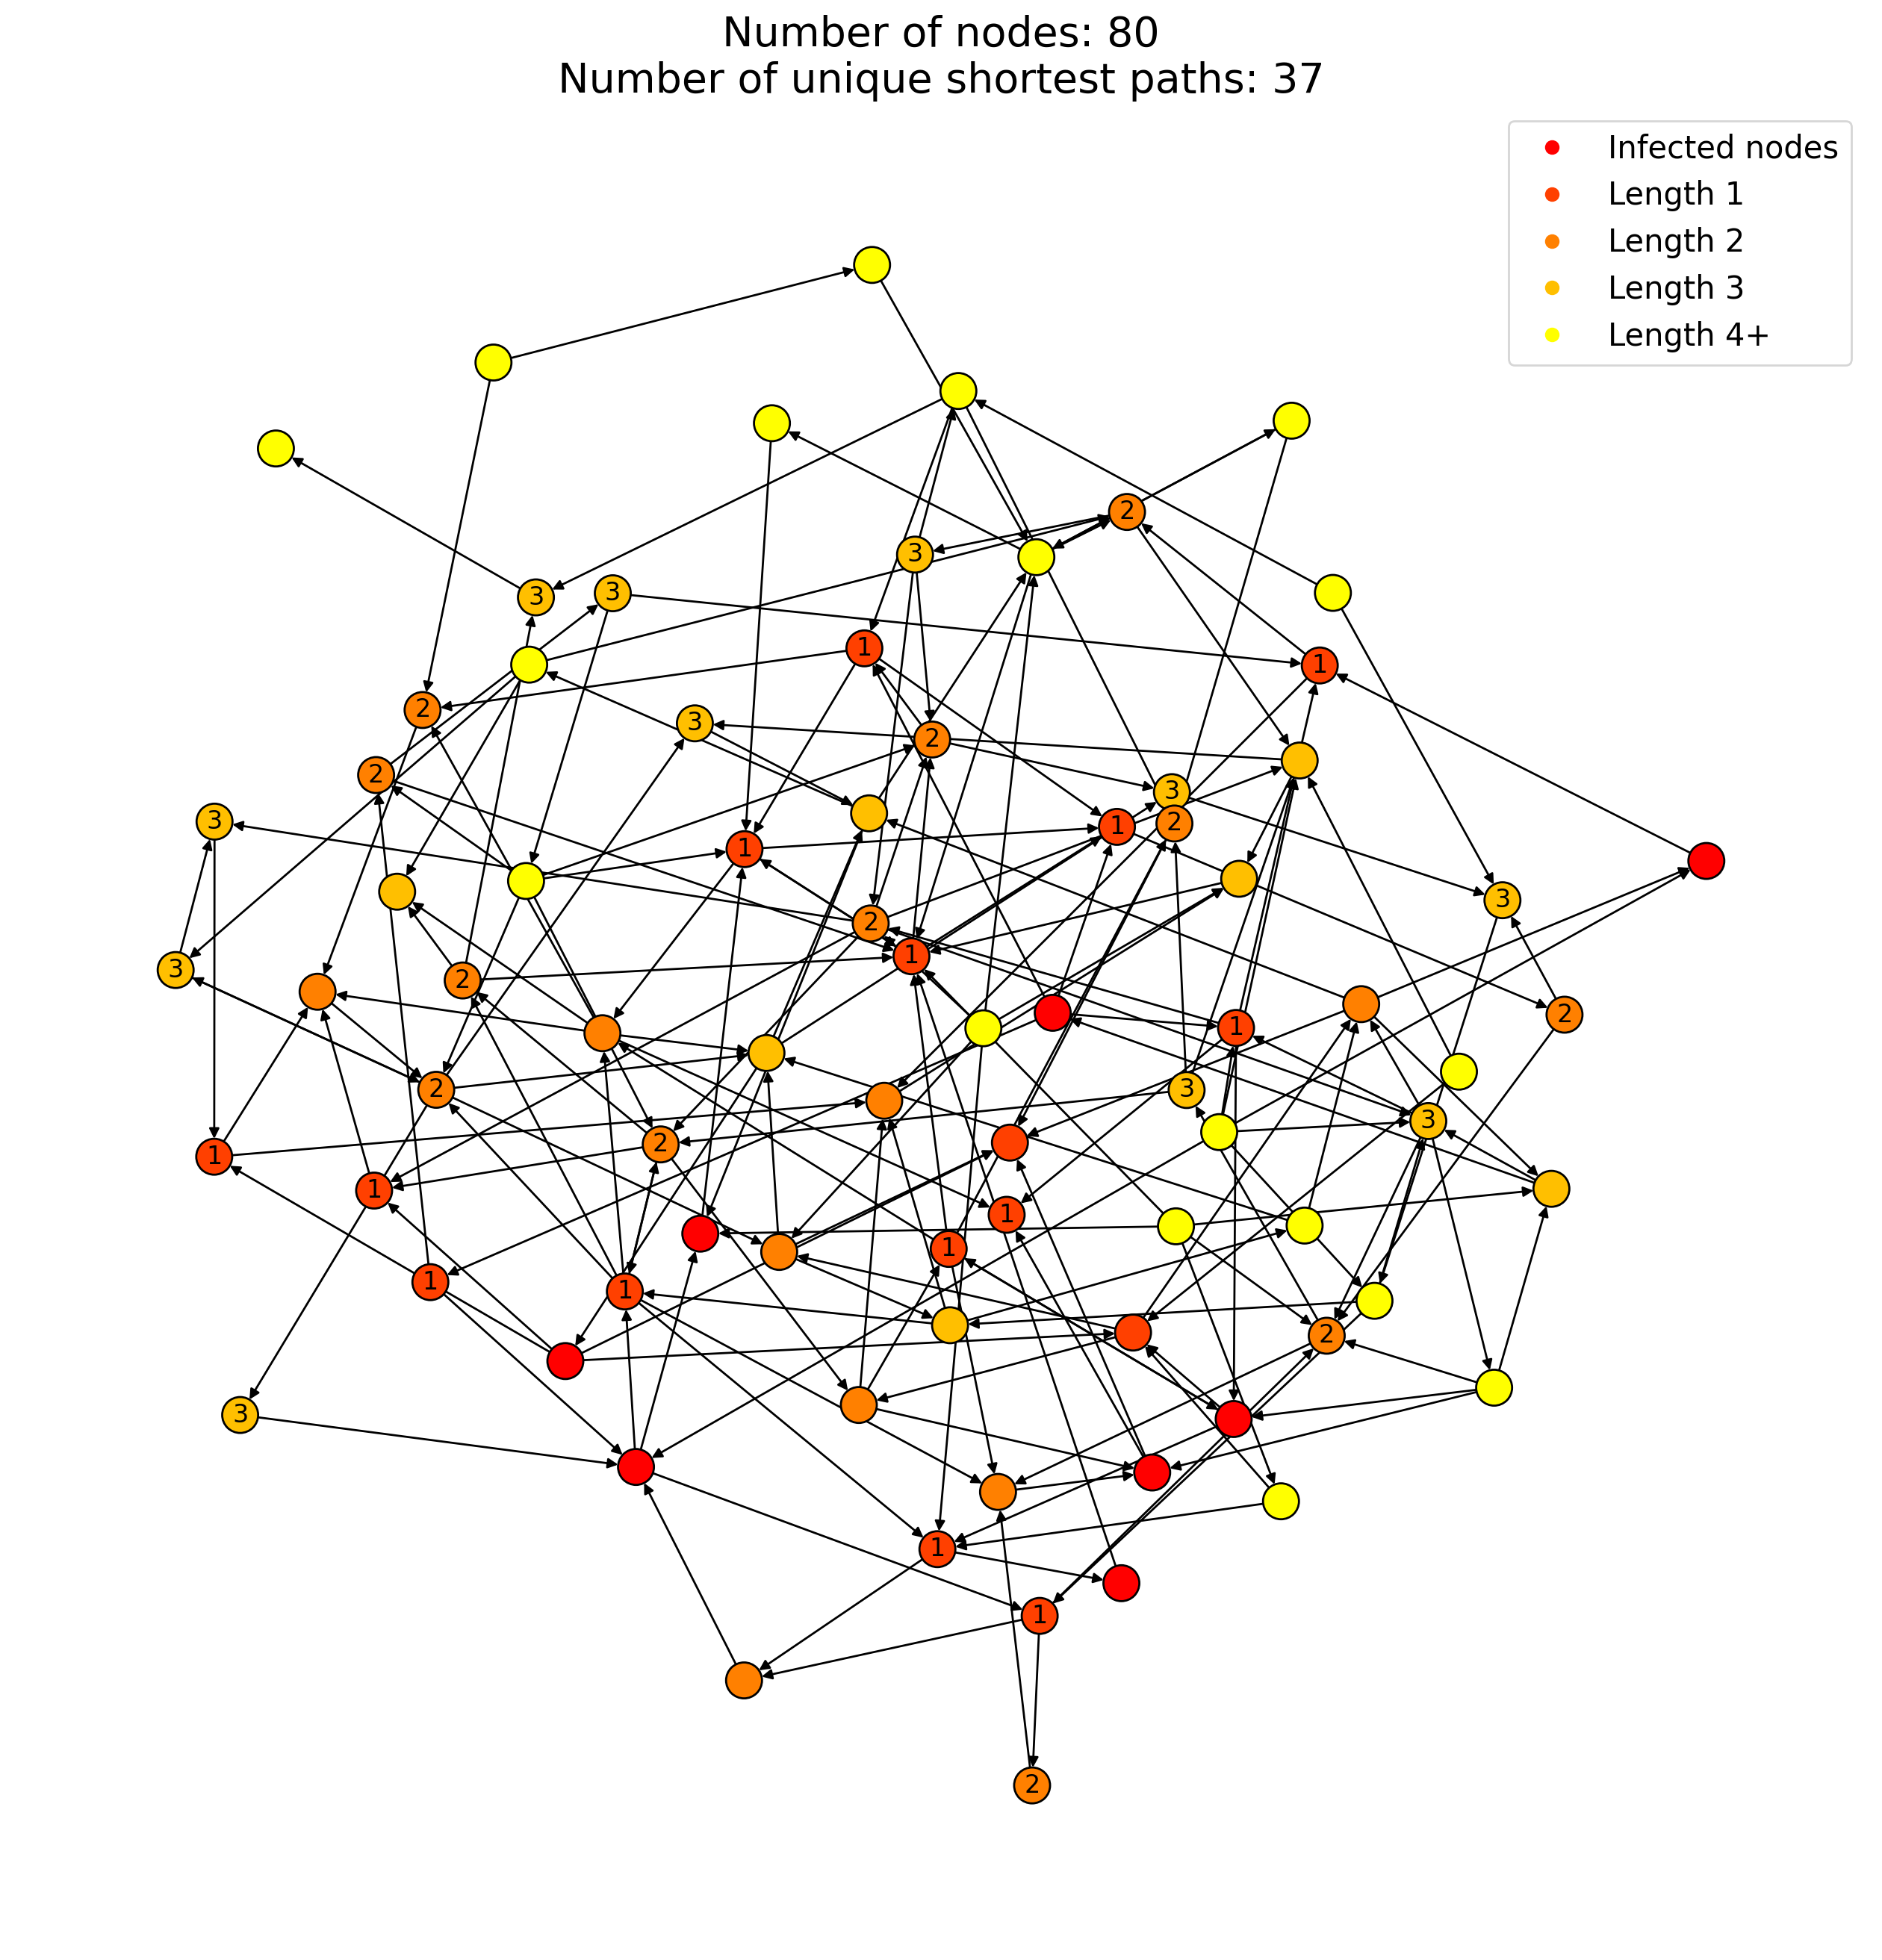

In [4]:
# draw_infection_data(data)

In [5]:
def draw_infection_data_original_labels(data, ax=None, figsize=(16, 16), dpi=200):
    # Get the number of classes for data
    num_classes = data.y.max().item() + 1
    # Set the size of the figure with dpi=200
    fig = plt.figure(figsize=figsize, dpi=dpi)
    # Create a new axis if ax is None
    if ax is None:
        ax = fig.add_subplot(111)
    # Convert the data to networkx graph
    g = to_networkx(data)
    # Create a colormap for the labels
    cmap = plt.get_cmap("autumn", data.num_classes)
    # Create a list of colors for the nodes
    # where its color is determined by the label.
    node_colors = [cmap(data.y[i].item() / num_classes) for i in range(data.num_nodes)]
    # unique_solution_explanations = {
    #     node: f"{data.y[node].item()}"
    #     for  node in data.unique_solution_nodes
    # }
    # Draw the graph with node outline as black
    nx.draw(
        g,
        pos=nx.kamada_kawai_layout(g),
        node_color=node_colors,
        edgecolors="black",
        ax=ax,
        # labels=unique_solution_explanations,
        with_labels=True,
        arrows=True,
    )
    # Draw the legend
    # Create a list of handles for the legend
    handles = [
        plt.Line2D(
            [],
            [],
            color=cmap(i / num_classes),
            marker="o",
            linestyle="",
            label=f"Length {i}",
        )
        for i in range(data.num_classes)
    ]
    # Explicitly mention infected nodes in legend
    handles[0].set_label(f"Infected nodes")
    # Replace the highest category by appending + symbol
    handles[-1].set_label(f"Length {data.num_classes - 1}+")

    # Make some adjustments
    ax.legend(
        handles=handles,
        loc="upper right",
        fontsize=15,
    )
    # Remove the axis
    ax.axis("off")
    # Set the title, including the number of nodes, number of ground truth shortest paths
    # and the number of unique shortest paths
    ax.set_title(
        f"Number of nodes: {data.num_nodes}\n"
        f"Number of unique shortest paths: {len(data.unique_solution_nodes)}",
        fontsize=20,
    )
    # Show the plot
    plt.show()

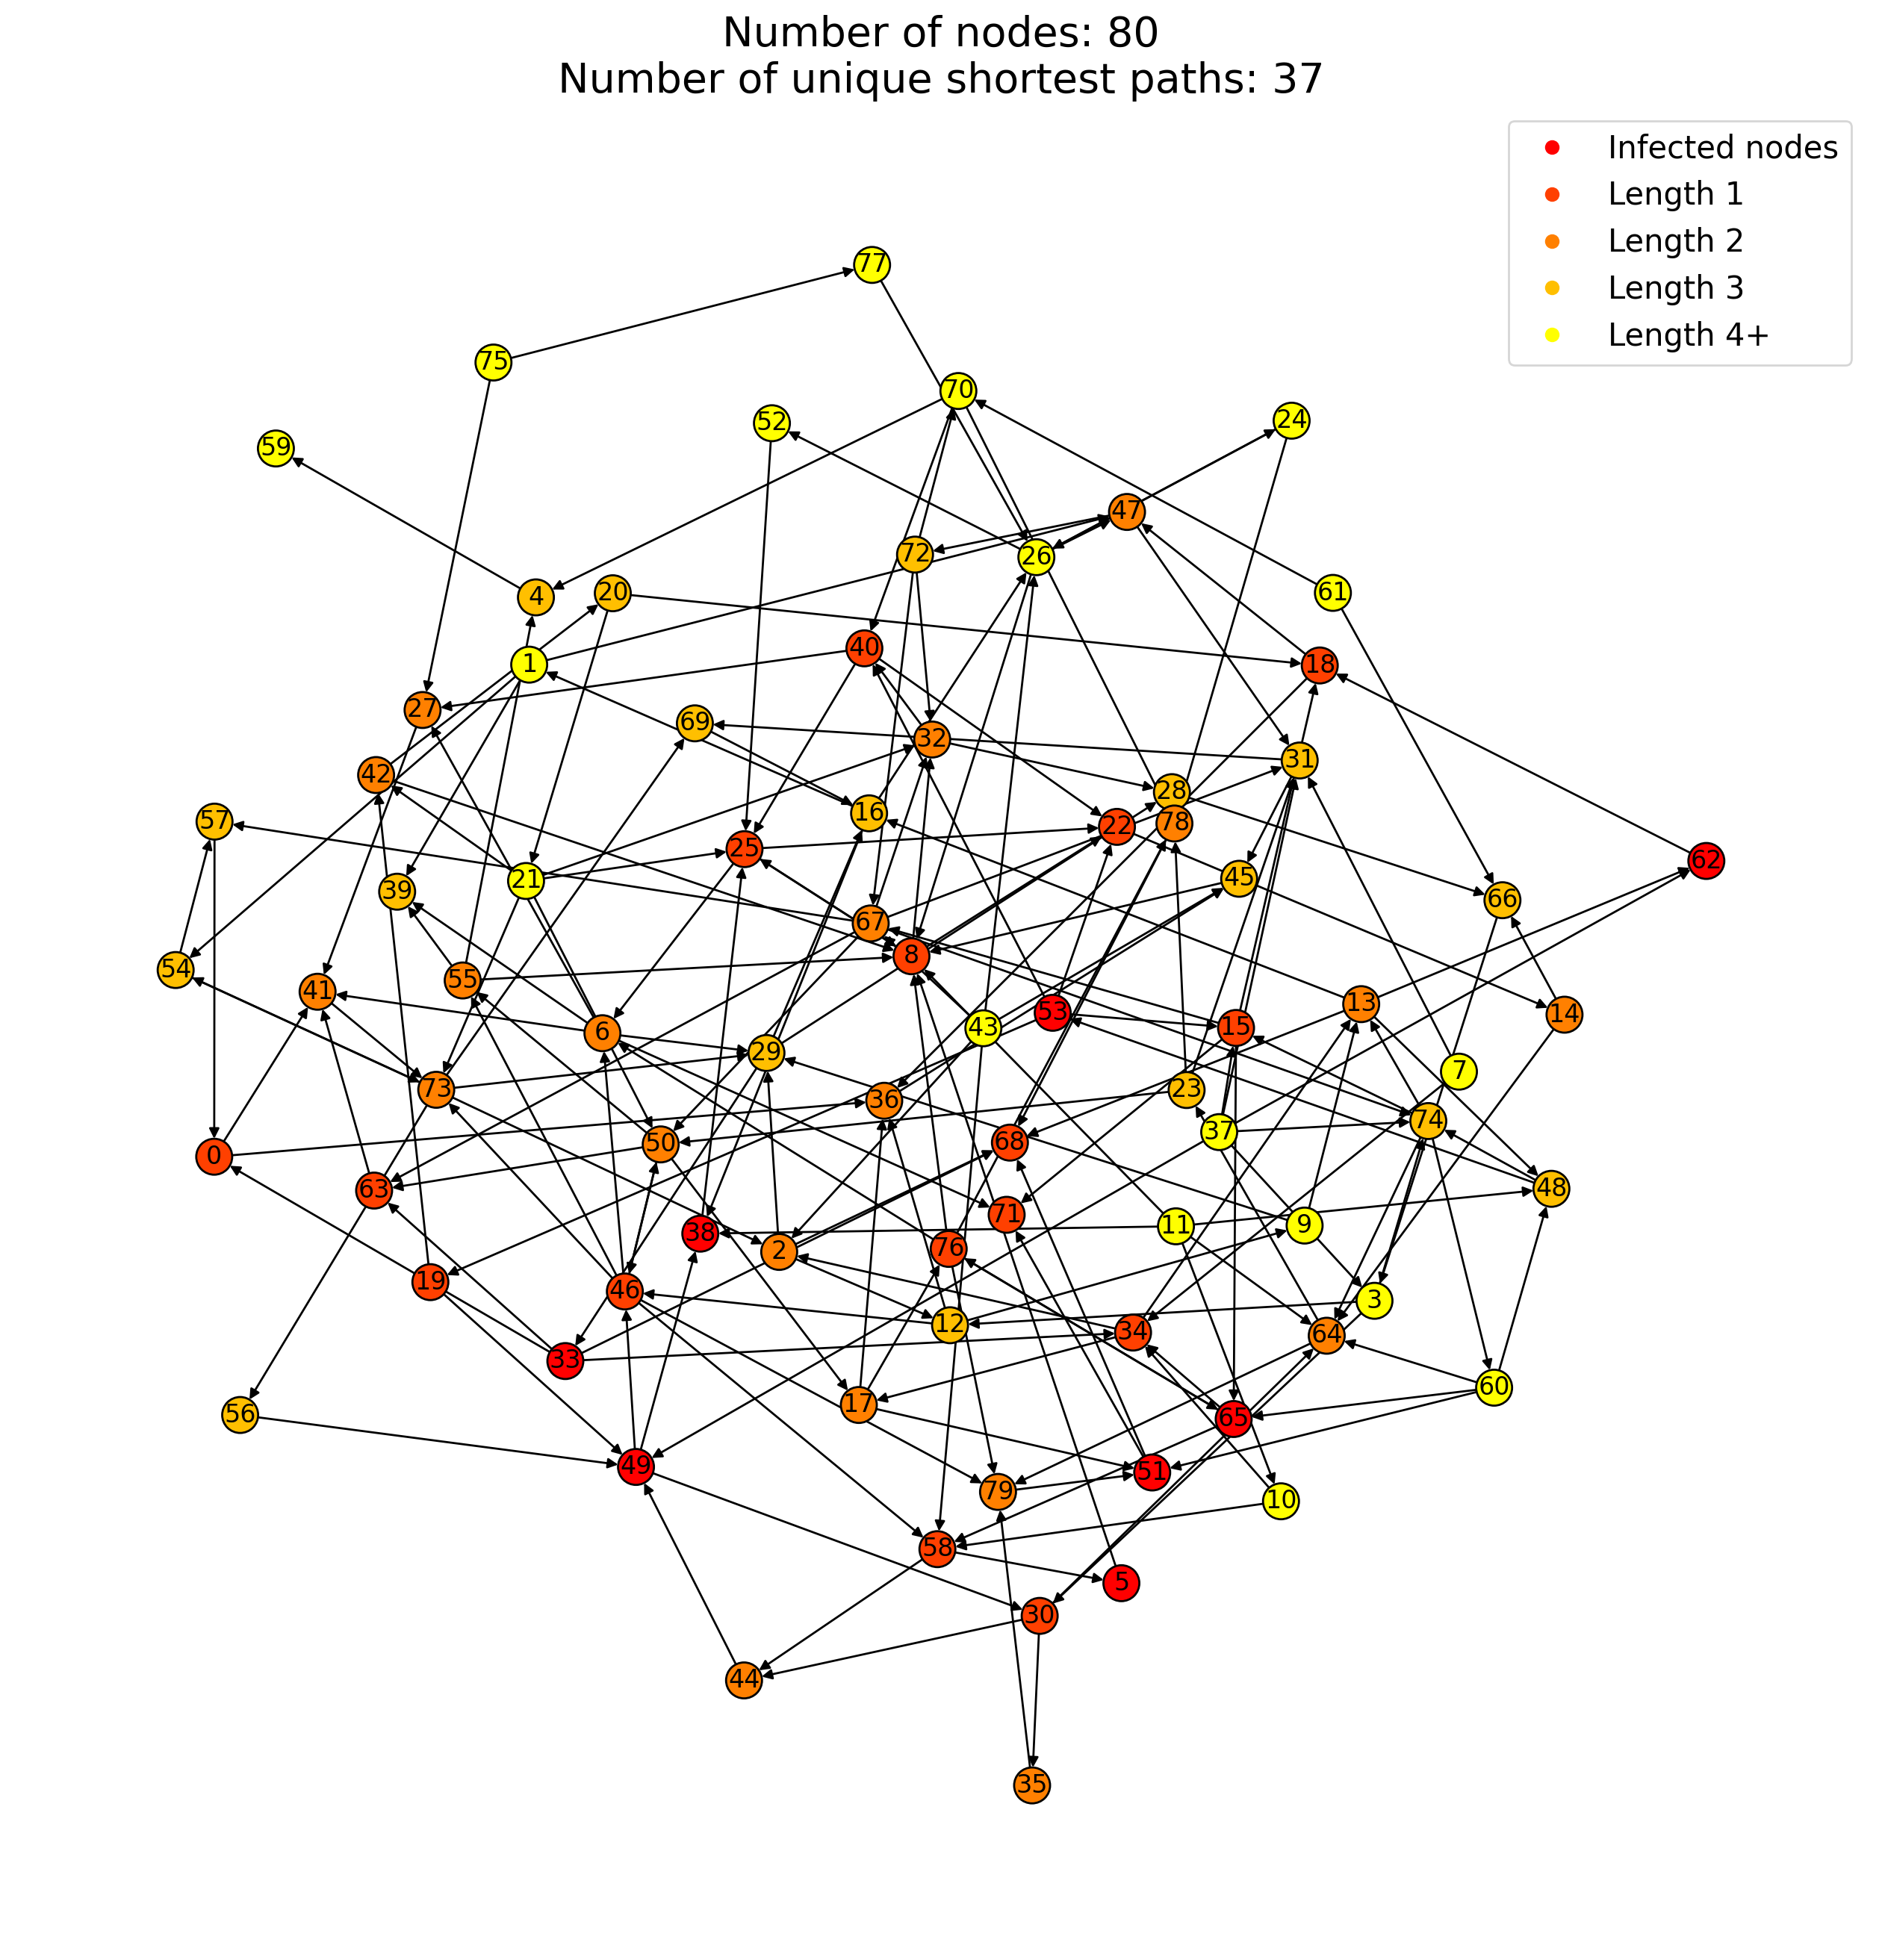

In [6]:
# draw_infection_data_original_labels(data)

In [7]:
# Save the network data locally (for reproduction)
# torch.save(data, "/workspace/Infection_dataset_small.pt")

In [310]:
# Load the network data locally (for reproduction)
data = torch.load("/workspace/Infection_dataset_small.pt")

In [9]:
# # Train an GAT model with train/test splits and also save locally (for reproduction)
# from sklearn.model_selection import train_test_split

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # Define the node indices
# node_indices = torch.arange(data.num_nodes)
# # Split the node indices into training and test sets
# train_indices, test_indices = train_test_split(
#     node_indices, test_size=0.5, random_state=42
# )
# # Define the training and test masks
# train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
# test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
# # Set the training and test masks
# train_mask[train_indices] = True
# test_mask[test_indices] = True
# # Set the training and test masks
# data.train_mask = train_mask
# data.test_mask = test_mask
# data = data.to(device)

# out_channels = data.y.max().item() + 1

# # Define several GAT models with 1, 2, 4, 8 attention heads to be used for 'data.pt', and move them to the GPU device (if available)
# model = GAT_L2(in_channels=2, hidden_channels=8, out_channels=out_channels, heads=1).to(
#     device
# )


# def train(model, data, optimizer, epochs: int):
#     # Set the model to training mode
#     model.train()
#     # Define the criterion
#     criterion = torch.nn.CrossEntropyLoss()
#     # Full batch training
#     for _ in range(epochs):
#         # Zero out the gradients
#         optimizer.zero_grad()
#         # Perform the forward pass
#         out = model(data.x, data.edge_index)
#         # Compute the loss
#         loss = criterion(out[data.train_mask], data.y[data.train_mask])
#         # Compute the accuracy
#         acc = (
#             out[data.train_mask].argmax(dim=1) == data.y[data.train_mask]
#         ).sum().item() / data.train_mask.sum().item()
#         # Perform the backward pass
#         loss.backward()
#         # Perform the optimization step
#         optimizer.step()
#     return model, loss, acc


# @torch.no_grad()
# def test(model, data):
#     # Set the model to evaluation mode
#     model.eval()
#     # Define the test loss
#     loss = 0
#     # Define the test accuracy
#     acc = 0
#     # Define the criterion
#     criterion = torch.nn.CrossEntropyLoss()
#     # Get the test data
#     x, edge_index, y = data.x, data.edge_index, data.y
#     # Get the output of the model
#     out = model(x, edge_index)
#     # Compute the loss
#     loss = criterion(out[test_mask], y[test_mask])
#     # Compute the test accuracy
#     acc = (out[test_mask].argmax(dim=1) == y[test_mask]).sum().item() / y[
#         test_mask
#     ].size(0)
#     # Return the test loss and the test accuracy
#     return loss, acc


# epochs = 500
# lr = 0.01
# optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)
# model, loss, acc = train(model=model, data=data, optimizer=optimizer, epochs=epochs)
# test_loss, test_acc = test(model=model, data=data)

# print(
#     f"Model: GAT_infection_2L1H, Loss: {loss:.4f}, Train Accuracy: {acc:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}"
# )

Model: GAT_infection_2L1H, Loss: 0.4808, Train Accuracy: 0.7750, Test Loss: 0.7041, Test Accuracy: 0.6250


In [10]:
# Save model as a whole
# torch.save(model, "/workspace/GAT_infection_small.pt")

In [12]:
# Load model as a whole
model = torch.load("/workspace/GAT_infection_small.pt")
model.eval()

GAT_L2(
  (conv1): GATConv(2, 8, heads=1)
  (conv2): GATConv(8, 5, heads=1)
)

In [75]:
@torch.no_grad()
def get_attention_raw_dict(model, data) -> Dict:
    num_layers = get_num_hops(model)
    model(data.x, data.edge_index, return_att=True)
    attention_dict = {}
    for layer in range(num_layers):
        attention_dict[layer] = model.att[layer]

    return attention_dict


def process_attention_dict(att_dict: Dict) -> Dict:
    att_dict_processed = {}
    for layer, att in att_dict.items():
        curr_edge_index = att[0]
        curr_att_tensor = att[1]
        curr_att_dict = {}
        for idx in range(curr_edge_index.shape[1]):
            curr_edge = (curr_edge_index[0][idx].item(), curr_edge_index[1][idx].item())
            curr_att_dict[curr_edge] = curr_att_tensor[idx].item()
        att_dict_processed[layer] = curr_att_dict
    return att_dict_processed


def get_nodes_per_level_from_comp_graph_full(comp_graph):
    # Get list of nodes for each level, in the original node index
    nodes_per_level_original = [
        comp_graph[0][1][0].view(1)
    ]  # Initialize the list with the target node
    for idx in range(len(comp_graph)):
        nodes_per_level_original.append(comp_graph[idx][0])
    # And get the number of nodes in each level
    num_nodes_per_level = torch.tensor(
        [len(node_tensor) for node_tensor in nodes_per_level_original]
    )
    # And the true node label (for visualization)
    nodes_per_level_original_concat = torch.cat(nodes_per_level_original, dim=0)
    true_node_label = dict(
        zip(
            range(len(nodes_per_level_original_concat)),
            nodes_per_level_original_concat.tolist(),
        )
    )
    return nodes_per_level_original, num_nodes_per_level, true_node_label


def get_att_dict_per_layer(comp_graph, comp_graph_new, att_dict):
    layer_att_dict = {}
    for curr_layer in range(len(comp_graph)):
        curr_att_dict = att_dict[curr_layer]
        curr_edge_index = comp_graph[curr_layer]
        curr_edge_index_new = comp_graph_new[curr_layer]

        curr_layer_att_dict = {}
        for idx in range(curr_edge_index_new.shape[1]):
            curr_edge = (curr_edge_index[0][idx].item(), curr_edge_index[1][idx].item())
            curr_edge_new = (
                curr_edge_index_new[0][idx].item(),
                curr_edge_index_new[1][idx].item(),
            )
            curr_att = curr_att_dict[curr_edge]
            curr_layer_att_dict[curr_edge_new] = curr_att
        layer_att_dict[curr_layer] = curr_layer_att_dict
    return layer_att_dict


def visualize_computation_graph(layer_att_dict, nodes_per_level_new, true_node_label):
    # Visualize the computation graph with the attention weights, pre-defined node positions
    comp_G = nx.DiGraph()
    for layer, att_dict in layer_att_dict.items():
        for edge, att in att_dict.items():
            comp_G.add_edge(edge[0], edge[1], weight=att)

    # Get the edge weights
    edge_weights = [comp_G[u][v]["weight"] for u, v in comp_G.edges()]

    # Get the node positions
    node_pos = get_node_positions(nodes_per_level_new=nodes_per_level_new)

    # Draw the graph with the node positions and the edge weights
    # Define the width and height of the figure adaptively with the number of nodes
    figsize = (int(len(nodes_per_level_new[-1]) * 1), len(nodes_per_level_new) * 1.5)
    fig = plt.figure(figsize=figsize, dpi=120)
    # Set axis in the figure
    ax = fig.add_axes([0, 0, 1, 1])

    # Set the colormap
    cmap = plt.cm.coolwarm
    axfig = nx.draw(
        comp_G,
        pos=node_pos,
        node_color="#3bbcd9",
        node_size=1000,
        font_size=20,
        edgecolors="black",
        linewidths=2,
        edge_color=edge_weights,
        width=2,
        edge_vmin=0,
        edge_vmax=1,
        edge_cmap=cmap,
        arrowstyle="-|>",
        labels=true_node_label,
        with_labels=True,
        connectionstyle="angle3",
        font_weight="bold",
        ax=ax,
    )
    # Also show the colormap as legend on the side
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []
    plt.colorbar(sm, ax=ax)
    plt.show()

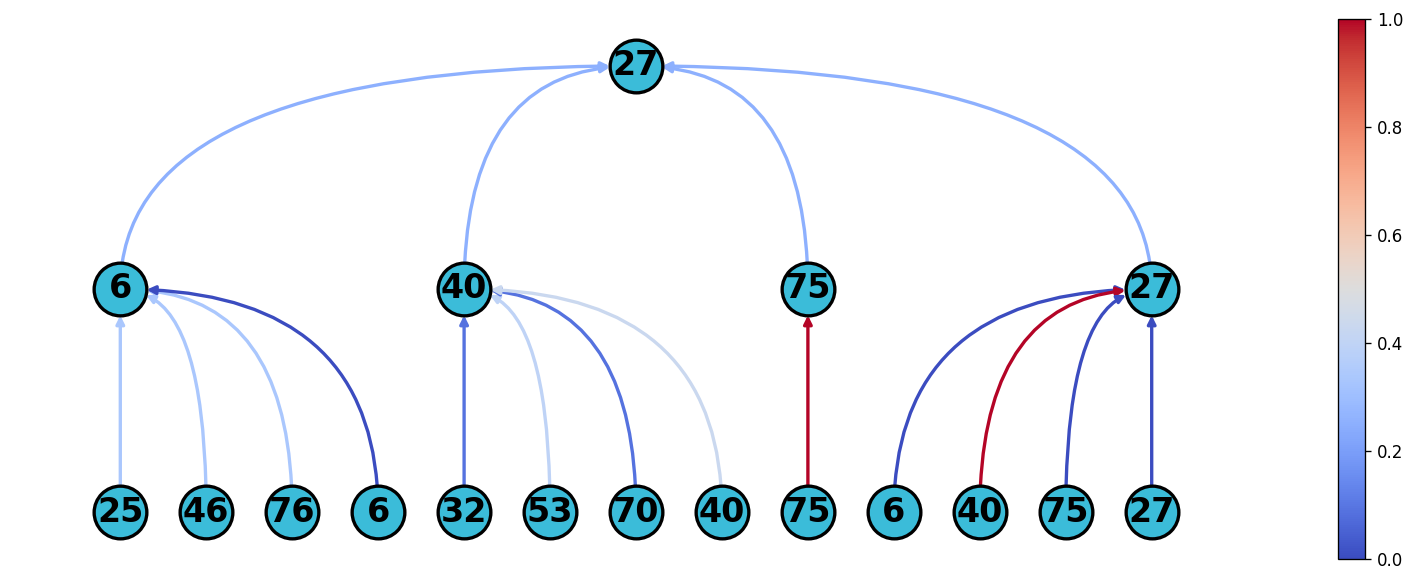

In [83]:
target_idx = 27
num_layers = get_num_hops(model)

att_dict_raw = get_attention_raw_dict(model, data)
att_dict = process_attention_dict(att_dict_raw)
comp_graph = get_computation_graph(
    edge_index=data.edge_index, k=num_layers, target_idx=target_idx
)
(
    nodes_per_level_original,
    num_nodes_per_level,
    true_node_label,
) = get_nodes_per_level_from_comp_graph_full(comp_graph=comp_graph)
nodes_per_level_new = reindex_nodes_per_level(
    nodes_per_level_original, num_nodes_per_level
)
comp_graph_new = translate_comp_graph(
    comp_graph=comp_graph,
    nodes_per_level_new=nodes_per_level_new,
    nodes_per_level_original=nodes_per_level_original,
)
layer_att_dict = get_att_dict_per_layer(
    comp_graph=comp_graph, comp_graph_new=comp_graph_new, att_dict=att_dict
)
visualize_computation_graph(
    layer_att_dict=layer_att_dict,
    nodes_per_level_new=nodes_per_level_new,
    true_node_label=true_node_label,
)

In [47]:
# Check if the model has correctly predicted the target node
with torch.no_grad():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    print("Prediction: ", pred[target_idx].item())

Prediction:  2


In [48]:
# Draw the k hop subgraph (not the computation graph)
from torch_geometric.utils import k_hop_subgraph

k = 2
subgraph_nodes, _, _, inv = k_hop_subgraph(
    target_idx, k, data.edge_index, relabel_nodes=True
)
subgraph_nodes = subgraph_nodes.tolist()

In [49]:
subgraph_nodes

[6, 25, 27, 32, 40, 46, 53, 70, 75, 76]

In [50]:
subgraph_edges = data.edge_index[:, inv].tolist()

In [51]:
# Transform subgraph_edges to a list of tuples
subgraph_edges_tup = [
    (subgraph_edges[0][i], subgraph_edges[1][i]) for i in range(len(subgraph_edges[0]))
]

G = nx.DiGraph()
G.add_edges_from(subgraph_edges_tup)

In [52]:
# Get index of target node in data.unique_solution_nodes
target_idx_in_unique_solution_nodes = data.unique_solution_nodes.index(target_idx)

In [53]:
# Get the ground truth path for target node
ground_truth_path = data.unique_solution_explanations[
    target_idx_in_unique_solution_nodes
]

In [54]:
# Convert the ground truth path to a list of tuples
ground_truth_path_tup = [
    (ground_truth_path[i], ground_truth_path[i + 1])
    for i in range(len(ground_truth_path) - 1)
]

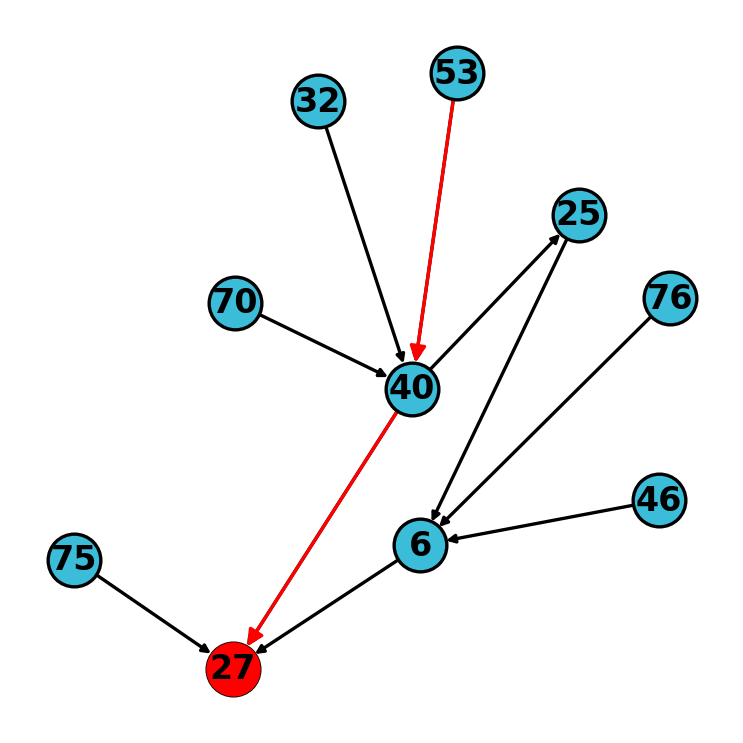

In [57]:
# Draw the graph with subgraph_nodes as node labels
# Highlight the path from ground_truth_path_tup with red edges
# Also highlight the target node with a different color
plt.figure(figsize=(6, 6), dpi=120)
pos = nx.spring_layout(G, seed=0)
nx.draw(
    G,
    pos=pos,
    node_color="#3bbcd9",
    node_size=1000,
    font_size=20,
    width=2,
    edgecolors="black",
    linewidths=2,
    edge_color="black",
    arrowstyle="-|>",
    labels={node: node for node in subgraph_nodes},
    with_labels=True,
    font_weight="bold",
)
nx.draw_networkx_edges(
    G,
    pos=pos,
    edgelist=ground_truth_path_tup,
    edge_color="red",
    width=2,
    arrows=True,
    arrowsize=20,
    node_size=1000,
)
nx.draw_networkx_nodes(
    G, pos=pos, nodelist=[target_idx], node_color="red", node_size=1000
)
plt.show()

In [ ]:
# Let's turn the process of drawing the local graph with the ground truth path into a function
def draw_local_comp_graph_with_ground_truth_path(data: Data, hops: int, target_idx: int) -> None:
    # First assert that the target index does have a unique ground truth path
    assert target_idx in data.unique_solution_nodes, "Target index does not have a unique ground truth path"
    # Get the local k hop subgraph
    subgraph_nodes, _, _, inv = k_hop_subgraph(
    node_idx=target_idx, num_hops=hops, edge_index=data.edge_index, relabel_nodes=True
    )
    # Convert nodes and edges to lists
    subgraph_nodes = subgraph_nodes.tolist()
    subgraph_edges = data.edge_index[:, inv].tolist()
    # Transform subgraph_edges to a list of tuples
    subgraph_edges_tup = [
        (subgraph_edges[0][i], subgraph_edges[1][i]) for i in range(len(subgraph_edges[0]))
    ]
    # Create a directed graph
    G = nx.DiGraph()
    G.add_edges_from(subgraph_edges_tup)
    # Get index of target node in data.unique_solution_nodes
    target_idx_in_unique_solution_nodes = data.unique_solution_nodes.index(target_idx)
    # Get the ground truth path for target node
    ground_truth_path = data.unique_solution_explanations[
        target_idx_in_unique_solution_nodes
    ]
    # Convert the ground truth path to a list of tuples
    ground_truth_path_tup = [
        (ground_truth_path[i], ground_truth_path[i + 1])
        for i in range(len(ground_truth_path) - 1)
    ]
    # Draw the graph with subgraph_nodes as node labels
    # Highlight the path from ground_truth_path_tup with red edges
    # Also highlight the target node with a different color
    plt.figure(figsize=(6, 6), dpi=120)
    pos = nx.spring_layout(G, seed=0)
    nx.draw(
        G,
        pos=pos,
        node_color="#3bbcd9",
        node_size=1000,
        font_size=20,
        width=2,
        edgecolors="black",
        linewidths=2,
        edge_color="black",
        arrowstyle="-|>",
        labels={node: node for node in subgraph_nodes},
        with_labels=True,
        font_weight="bold",
    )
    nx.draw_networkx_edges(
        G,
        pos=pos,
        edgelist=ground_truth_path_tup,
        edge_color="red",
        width=2,
        arrows=True,
        arrowsize=20,
        node_size=1000,
    )
    nx.draw_networkx_nodes(
        G, pos=pos, nodelist=[target_idx], node_color="red", node_size=1000
    )
    plt.show()

In [77]:
data.edge_index.shape[1]

195

In [311]:
27 in data.unique_solution_nodes

True

In [78]:
data.num_nodes

80

## Test with the big one

In [200]:
# First, load the dataset from local
data = torch.load("/workspace/Infection_50003d.pt").cpu()
# Also import the model
model = torch.load("/workspace/GAT_infection_3L1H.pt").cpu()

In [216]:
# Let's get the lowest degree node and see how the attention weights are distributed
from torch_geometric.utils import degree

# Get the degree of each node
deg = degree(data.edge_index[1])

# Get the 30~40th nodes with the lowest degree
deg_sorted = torch.argsort(deg)
deg_sorted = deg_sorted[30:40]

print("The 30~40th nodes with the lowest degree are: ", deg_sorted)

The 30~40th nodes with the lowest degree are:  tensor([ 572, 1720, 4304, 1387,  229,  902, 3220, 4068, 4142, 1360])


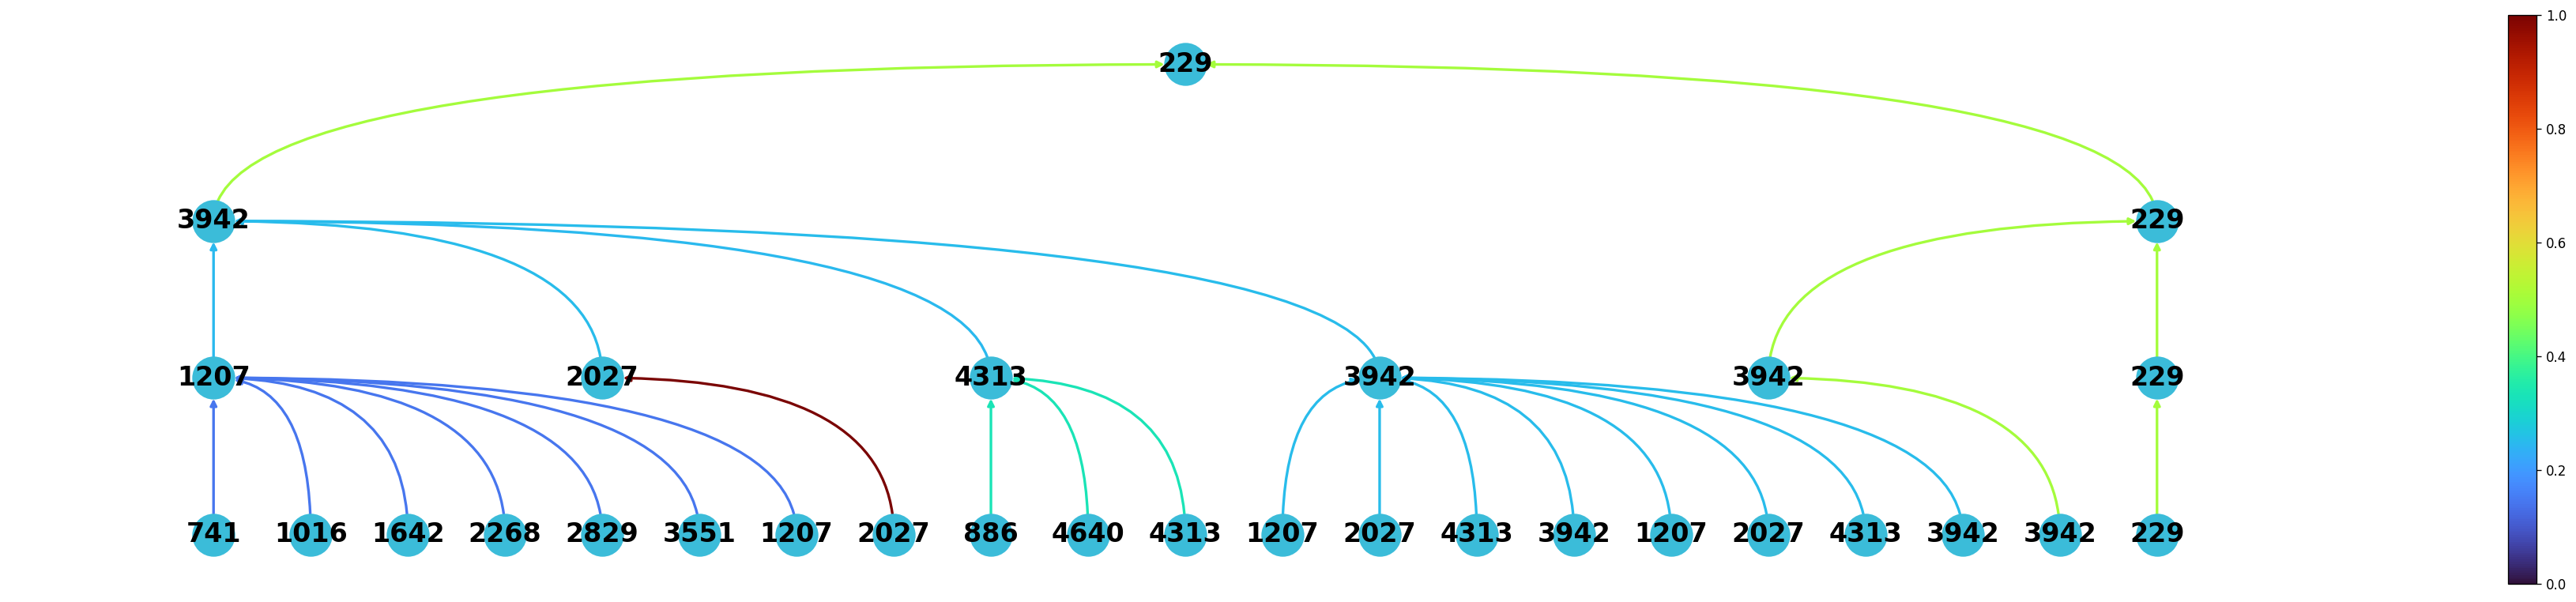

In [219]:
num_layers = get_num_hops(model)

att_dict_raw = get_attention_raw_dict(model, data)
att_dict = process_attention_dict(att_dict_raw)
comp_graph = get_computation_graph(
    edge_index=data.edge_index, k=num_layers, target_idx=target_idx
)
(
    nodes_per_level_original,
    num_nodes_per_level,
    true_node_label,
) = get_nodes_per_level_from_comp_graph_full(comp_graph=comp_graph)
nodes_per_level_new = reindex_nodes_per_level(
    nodes_per_level_original, num_nodes_per_level
)
comp_graph_new = translate_comp_graph(
    comp_graph=comp_graph,
    nodes_per_level_new=nodes_per_level_new,
    nodes_per_level_original=nodes_per_level_original,
)
layer_att_dict = get_att_dict_per_layer(
    comp_graph=comp_graph, comp_graph_new=comp_graph_new, att_dict=att_dict
)
visualize_computation_graph(
    layer_att_dict=layer_att_dict,
    nodes_per_level_new=nodes_per_level_new,
    true_node_label=true_node_label,
)

In [220]:
def visualizer(data, att_dict, num_layers, target_idx):
    comp_graph = get_computation_graph(
        edge_index=data.edge_index, k=num_layers, target_idx=target_idx
    )
    (
        nodes_per_level_original,
        num_nodes_per_level,
        true_node_label,
    ) = get_nodes_per_level_from_comp_graph_full(comp_graph=comp_graph)
    nodes_per_level_new = reindex_nodes_per_level(
        nodes_per_level_original, num_nodes_per_level
    )
    comp_graph_new = translate_comp_graph(
        comp_graph=comp_graph,
        nodes_per_level_new=nodes_per_level_new,
        nodes_per_level_original=nodes_per_level_original,
    )
    layer_att_dict = get_att_dict_per_layer(
        comp_graph=comp_graph, comp_graph_new=comp_graph_new, att_dict=att_dict
    )
    visualize_computation_graph(
        layer_att_dict=layer_att_dict,
        nodes_per_level_new=nodes_per_level_new,
        true_node_label=true_node_label,
    )

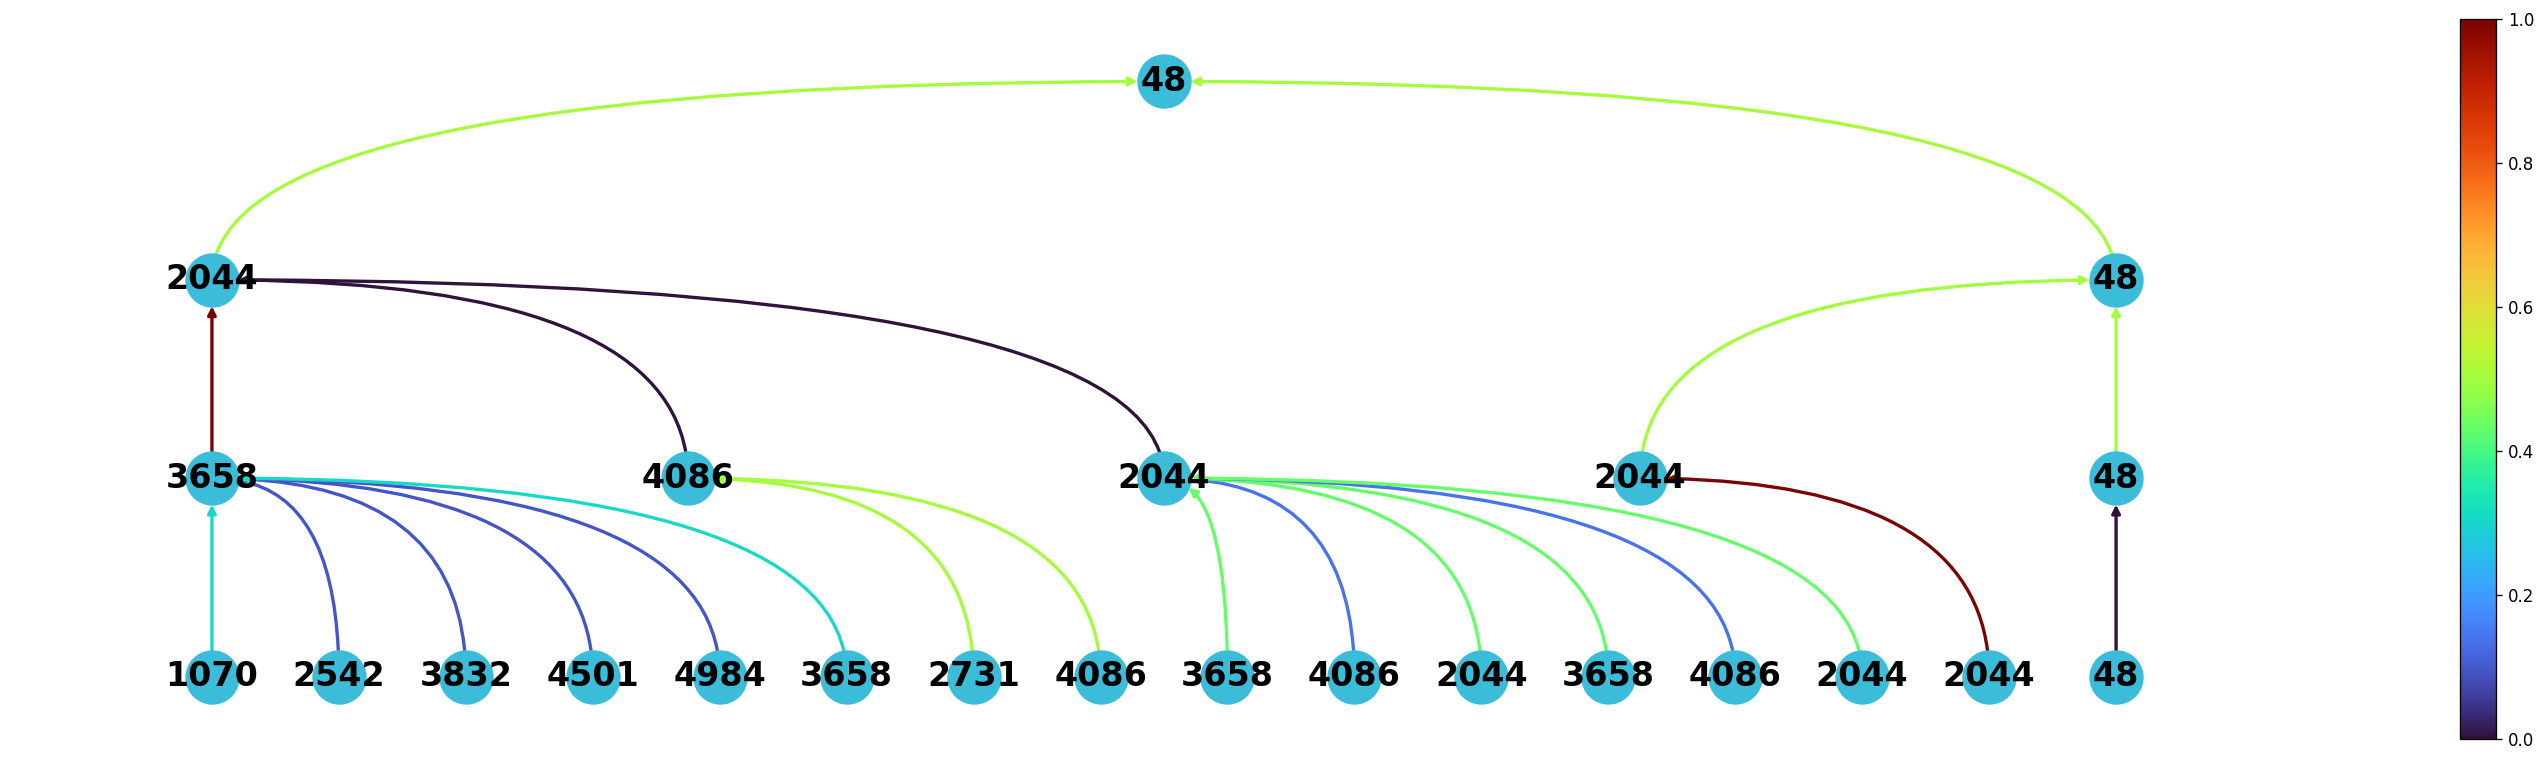

In [244]:
target_idx = 48
visualizer(data=data, att_dict=att_dict, num_layers=num_layers, target_idx=target_idx)